In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential,Model 
from keras.layers.core import Dense,Dropout,Activation,Flatten,Reshape
from keras.layers import Embedding,Input ,merge, ELU
from keras.layers.recurrent import SimpleRNN , LSTM 
from keras.layers.convolutional import Convolution2D , MaxPooling2D
from keras.optimizers import SGD ,Adam,RMSprop
from keras.regularizers import l2,l1
from keras.utils.np_utils import to_categorical 
from keras import backend as K
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
from keras.layers.convolutional import MaxPooling2D 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from numpy import array, newaxis, expand_dims
from keras.layers import GlobalMaxPooling2D
from keras.models import load_model
import math
import numpy as np
import matplotlib.pyplot as plt 

In [4]:
import glob #grab some files 
from tqdm import tqdm # to look at progress bars
import scipy # Used for image processing 
import scipy.misc
import pandas as pd
import h5py as hp


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
data=np.load('full_set.npz')
X_train=data['X_train']
X_test=data['X_test']
y_train=data['y_train']
y_test=data['y_test']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

steer_tr=y_train[:,2]
steer_ts=y_test[:,2]



(168416, 3, 80, 80)
(168416, 5)
(18709, 3, 80, 80)
(18709, 5)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


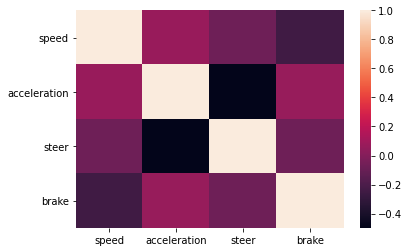

In [6]:
import seaborn as sns
#import matplotlib as plt
df1=pd.DataFrame(y_train,columns=['speed','acceleration','steer','brake'])
corr = df1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


This indicates that steering angle and acceleration have negative correlation ,while speed and gas have strong positive correlation.

In [8]:
accel_tr=y_train[:,1]
accel_ts=y_test[:,1]

In [9]:
speed_tr=y_train[:,0]
speed_ts=y_test[:,0]

In [31]:
brake_tr=y_train[:,3]
brake_ts=y_test[:,3]

In [11]:
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [ ]:
all_model=tf.keras.models.load_model('/content/drive/My Drive/Cam/all_model.h5')

In [ ]:
df1=pd.DataFrame(y_train,columns=['speed','accel','steer','brake'])
df1=df1.drop(['speed'],axis=1)
df1.head()
X_speed=df1.to_numpy()
X_speed.shape

(168416, 3)

In [ ]:
df2=pd.DataFrame(y_test,columns=['speed','accel','steer','brake'])
df2=df2.drop(['speed'],axis=1)
df2.head()
X_speed_tst=df2.to_numpy()
X_speed_tst.shape

(18709, 3)

In [17]:
def make_model_exp(X,Y):
    model=Sequential()
              #model.add(Dense(10,activation='relu')) #input layer
    model.add(Convolution2D(128,(3,3),input_shape=(3,80,80),activation='relu',data_format='channels_first')) #1st conv layer
    model.add(MaxPooling2D())       #pool_size=(2,2),data_format='channels_last'
    #x=modl(inputs)                  #add model layers
                      #model.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))
    model.add(Convolution2D(256,(3,3),activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D())
    #model.add(Dropout(0.5))
    #x=modl(inputs)           #pool_size=(2,2),data_format='channels_first
    model.add(Convolution2D(256,(3,3),activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D())
    #model.add(Dropout(0.25))
    #x=modl(inputs)     #pool_size=(2,2),data_format='channels_first'
    model.add(Convolution2D(128,(3,3),activation='relu',data_format='channels_first'))
    model.add(MaxPooling2D())
    #model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
    model.add(Convolution2D(128,(3,3),activation='relu',data_format='channels_first'))
    model.add(GlobalMaxPooling2D()) 
    #model.add(Dropout(0.2))
    #x=modl(inputs)        #
    #model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    #x=modl(inputs)
    model.add(Dense(64, activation='relu'))
    #x=modl(inputs)
    model.add(Dense(4,activation='linear'))
    #model= Model(inputs=inputs,outputs=outputs)
    print(model.summary())
    #adam = optimizer.Adam(lr=0.3)
    model.compile(loss='mse',optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])

    history = model.fit(X,Y, batch_size=64, epochs=15, validation_split=0.2)

    return history

In [19]:
full_model_mse=make_model_exp(X_train,y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 78, 78)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 39, 78)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 37, 76)       147712    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 18, 76)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 16, 74)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 8, 74)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 6, 72)       

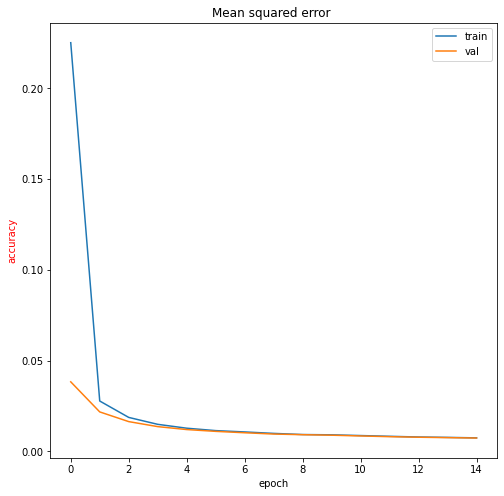

In [20]:
plt.rcParams["figure.figsize"] = (8,8)

plt.plot(full_model_mse.history['mean_squared_error'])
plt.plot(full_model_mse.history['val_mean_squared_error'])
plt.title('Mean squared error ')
plt.ylabel('accuracy',color='red')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

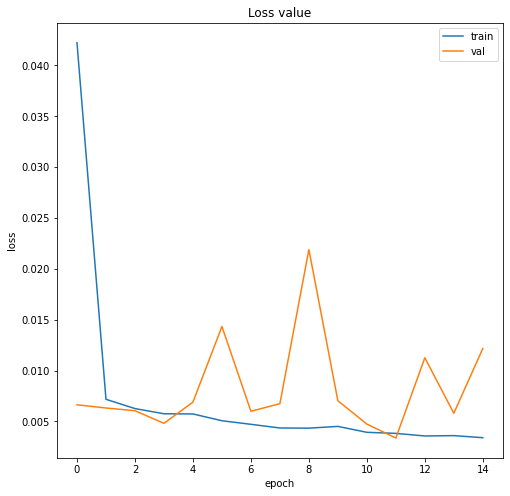

In [21]:
plt.plot(full_model_mse.history['loss'])
plt.plot(full_model_mse.history['val_loss'])
plt.title('Loss value')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

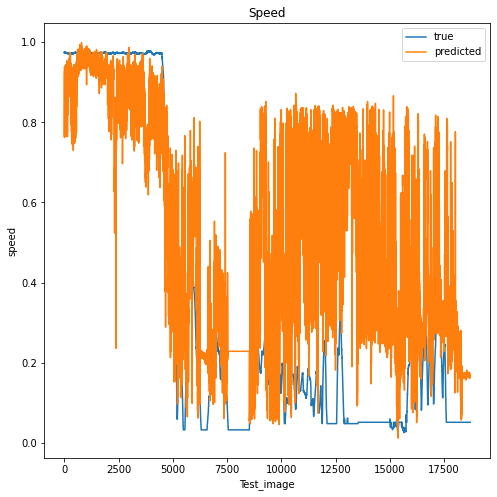

0.10120277


In [26]:
 
y_pred=full_model_mse.model.predict(X_test)
plt.plot(speed_ts)
plt.plot(y_pred[:,0])
plt.title('Speed')
plt.ylabel('speed')
plt.xlabel('Test_image')
plt.legend(['true', 'predicted'], loc='upper right')
plt.show()
mse=tf.keras.metrics.mean_squared_error(speed_ts, y_pred[:,0])
print(mse.numpy())
#mse(speed_ts, y_pred[:,0]).numpy()

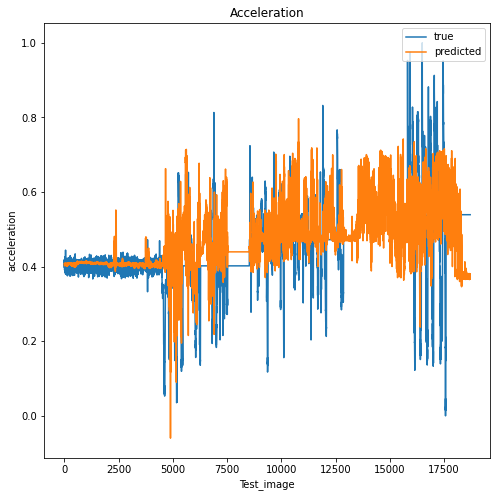

0.012248726


In [25]:
 
y_pred=full_model_mse.model.predict(X_test)
plt.plot(accel_ts)
plt.plot(y_pred[:,1])
plt.title('Acceleration')
plt.ylabel('acceleration')
plt.xlabel('Test_image')
plt.legend(['true', 'predicted'], loc='upper right')
plt.show()
mse=tf.keras.metrics.mean_squared_error(accel_ts, y_pred[:,1])
print(mse.numpy())
#mae(speed_ts, y_pred[:,0]).numpy()

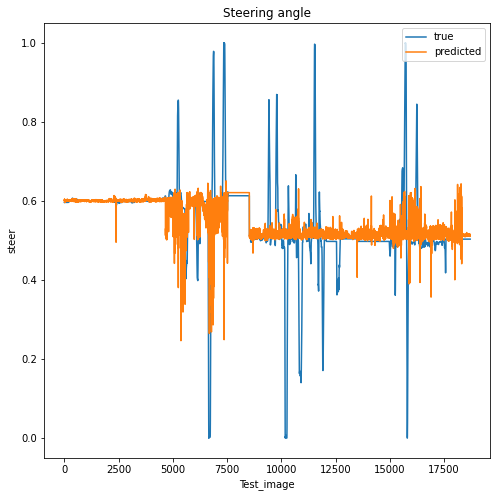

0.0098213805


In [28]:
y_pred=full_model_mse.model.predict(X_test)
plt.plot(steer_ts)
plt.plot(y_pred[:,2])
plt.title('Steering angle')
plt.ylabel('steer')
plt.xlabel('Test_image')
plt.legend(['true', 'predicted'], loc='upper right')
plt.show()
mse=tf.keras.metrics.mean_squared_error(steer_ts, y_pred[:,2])
print(mse.numpy())

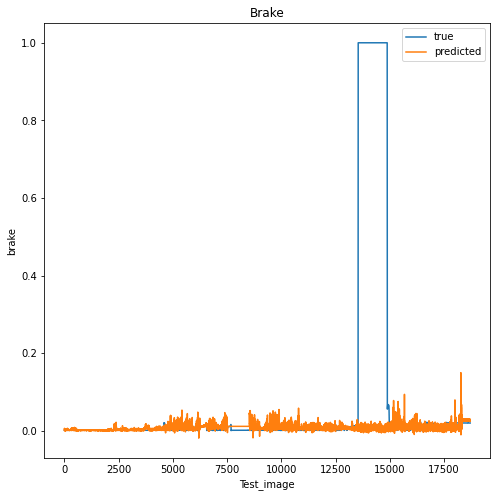

0.07094681


In [32]:
y_pred=full_model_mse.model.predict(X_test)
plt.plot(brake_ts)
plt.plot(y_pred[:,3])
plt.title('Brake')
plt.ylabel('brake')
plt.xlabel('Test_image')
plt.legend(['true', 'predicted'], loc='upper right')
plt.show()
mse=tf.keras.metrics.mean_squared_error(brake_ts, y_pred[:,3])
print(mse.numpy())

In [33]:
full_model_mse.model.save('full_model_mse.h5')

In [34]:
!cp '/content/full_model_mse.h5'  '/content/drive/My Drive/Cam/full_model_mse.h5'

In [6]:
full_model=tf.keras.models.load_model('full_model_mse.h5')

In [ ]:
y_pr=full_model.predict(X_test)